In [1]:
import pylhe
import ROOT
import math
import os
import pandas as pd
import uproot
import numpy as np
import matplotlib.pyplot as plt


Welcome to JupyROOT 6.20/04


In [2]:
sg_file = uproot.open("/data/event/sg_ppwax100/Events/run_01/tag_1_delphes_events.root") 
bg_file = uproot.open("/data/event/bg_sm100/Events/run_01/tag_1_delphes_events.root")

In [3]:
def file_np(file):
    event = [ file["Delphes;1"]["Electron"].array(),
              file["Delphes;1"]["Electron.PT"].array(),
              file["Delphes;1"]["Electron.Eta"].array(),
              file["Delphes;1"]["Electron.Phi"].array(),
              file["Delphes;1"]["Muon"].array(),                #4
              file["Delphes;1"]["Muon.PT"].array(),
              file["Delphes;1"]["Muon.Eta"].array(),
              file["Delphes;1"]["Muon.Phi"].array(),
              file["Delphes;1"]["Photon"].array(),              #8
              file["Delphes;1"]["Photon.PT"].array(),
              file["Delphes;1"]["Photon.Eta"].array(),
              file["Delphes;1"]["Photon.Phi"].array(),
              file["Delphes;1"]["MissingET"].array(),           #12
              file["Delphes;1"]["MissingET.fUniqueID"].array(),   
              file["Delphes;1"]["MissingET.fBits"].array(),
              file["Delphes;1"]["MissingET.MET"].array(),
              file["Delphes;1"]["MissingET.Eta"].array(),
              file["Delphes;1"]["MissingET.Phi"].array(),
              file["Delphes;1"]["Jet"].array(),                 #18
              file["Delphes;1"]["Jet.EhadOverEem"].array(),     
              file["Delphes;1"]["Jet.Mass"].array(),
              file["Delphes;1"]["Event.Number"].array(),
              file["Delphes;1"]["Jet.Tau[5]"].array()
              ]
    
    event = np.expand_dims(event, axis=-1)    ### reshape data
    event = event.transpose((1,0,2))
    event = np.squeeze(event,axis=(2,))
    return event 
    

In [4]:
bg_events = file_np(bg_file)
sg_events = file_np(sg_file)

In [61]:
m = 0.000511
def two_sl(event,lab,num):
    where1 = np.where(event[:,lab]==num)
    return event[where1]
######## number sel
def num_sl(event,lab,num):

    where1 = np.where(event[:,lab]==num)
    return event[where1]

######## cal multi mass(ex two e e)
def mll_fuc(event,labs,nums):

 c = len(two_sl(event,labs,nums))

 ept  = two_sl(event,labs,nums)[:,1]    
 eeta = two_sl(event,labs,nums)[:,2]
 ephi = two_sl(event,labs,nums)[:,3]
                             
 mll_list = [] 

 for i in range(c):
     p = [0,0,0,0]
     for j in range(nums):
         px = ept[i][j]*np.cos(ephi[i][j])
         py = ept[i][j]*np.sin(ephi[i][j])
         pz = ept[i][j]*np.sinh(eeta[i][j])
         p[1] = p[1] + px
         p[2] = p[2] + py
         p[3] = p[3] + pz
         p[0] = p[0] + np.sqrt((m**2) + px**2 + py**2 +pz**2)
     mll = np.sqrt(p[0]**2-p[3]**2-p[2]**2-p[1]**2)
     mll_list.append(mll)
 return mll_list
##########################cal l vl
def mlv_fuc(sel,mlv_list):
    m = 0.000511
    where1=[]
    lpt  = sel[:,1]    
    lphi = sel[:,2]
    leta = sel[:,3]
    vlpt  = sel[:,15]    
    vlphi = sel[:,16]
    vleta = sel[:,17]
    for i in range(len(sel)):
        p = [0,0,0,0]
        pt1 = lpt[i][0]
        eta1= leta[i][0]
        phi1= lphi[i][0]
        pt2 = vlpt[i][0]
        eta2= vleta[i][0]
        phi2= vlphi[i][0]
        
        px1 = pt1*np.cos(phi1) 
        px2 = pt2*np.cos(phi2)
        py1 = pt1*np.sin(phi1) 
        py2 = pt2*np.sin(phi2)
        pz1 = pt1*np.sinh(eta1) 
        pz2 = pt2*np.sinh(eta2)
        
        p[1] = p[1] + px1 + px2
        p[2] = p[2] + py1 + py2
        p[3] = p[3] + pz1 + pz2
        p[0] = p[0] + np.sqrt(m**2 + (px1)**2 + (py1)**2 + (pz1)**2) + np.sqrt((px2)**2 + (py2)**2 + (pz2)**2)
        mlv = np.sqrt(p[0]**2-p[3]**2-p[2]**2-p[1]**2)
#        if 0<mlv<250:
        mlv_list.append(mlv)
        where1.append(i)
    where = np.unique(where1)    
    return(sel[where])
########################################

def m_aa(events, m, pt1):
   
    for i in range(len(events)):
        p = [0,0,0,0]    ### four momentum
        for j in range(events[i][8]):
            pt = events[i][9][j]    ### 9:photon transverse momentum
            eta = events[i][10][j]    ### 10:photon polar angle
            phi = events[i][11][j]    ### 11:photon pseudorapidity
            p[1] = p[1] + pt*np.cos(phi)    ### px
            p[2] = p[2] + pt*np.sin(phi)    ### py
            p[3] = p[3] + pt*np.sinh(eta)    ### pz
            p[0] = p[0] + np.sqrt( (pt*np.cos(phi))**2 + (pt*np.sin(phi))**2 + (pt*np.sinh(eta))**2 )    ### energy with photon mass=0    
        maa = np.sqrt(p[0]**2 - p[1]**2 - p[2]**2 - p[3]**2)
        m.append(maa)
        pTaa = np.sqrt(p[1]**2 + p[2]**2)
        pt1.append(pTaa)
#///////////////////////////////////////////

def ptsl(events,selpt):
    for i in range(len(events)):
        p = [0,0,0,0]    ### four momentum
        for j in range(events[i][8]):
            pt = events[i][9][j]    ### 9:photon transverse momentum
            eta = events[i][10][j]    ### 10:photon polar angle
            phi = events[i][11][j]    ### 11:photon pseudorapidity
            p[1] = p[1] + pt*np.cos(phi)    ### px
            p[2] = p[2] + pt*np.sin(phi)    ### py
        pTaa = np.sqrt(p[1]**2 + p[2]**2)
        if pTaa > 50:
            selpt.append(pTaa)

################################        
        
def sel_m(mlist,msl,down,up):
    for i in mlist:
        if down<i<up:
            msl.append(i)


sg after 2aa sl : 4520
sg after 2aa_1e sl : 1366
sg after 2aa_1u sl : 1602

bg after 2aa sl : 4056
bg after 2aa_1e sl : 1055
bg after 2aa_1u sl : 1394

sg_2aa_1e 90<maa<110 : 1346
bg_2aa_1e 90<maa<110 : 33

sg_2aa_1u 90<maa<110 : 1563
bg_2aa_1u 90<maa<110 : 41

sg_2aa_1l 90<maa<110 : 2909
bg_2aa_1l 90<maa<110 : 74


<function matplotlib.pyplot.show(close=None, block=None)>

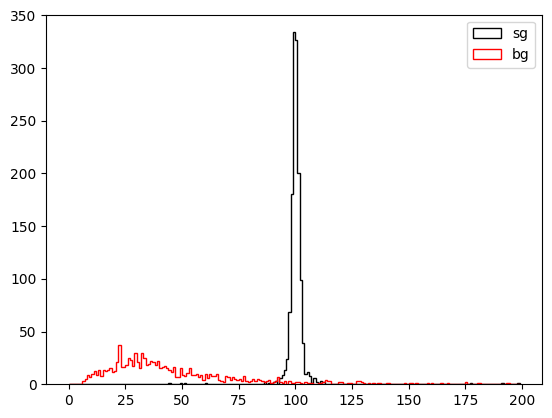

In [62]:
sgsl_2a = num_sl(sg_events,8,2)
sgsl_2a_1e =  num_sl(sgsl_2a,0,1)
sgsl_2a_1u =  num_sl(sgsl_2a,4,1)

print('sg after 2aa sl :',len(sgsl_2a))
print('sg after 2aa_1e sl :',len(sgsl_2a_1e))
print('sg after 2aa_1u sl :',len(sgsl_2a_1u))
print('')

bgsl_2a = num_sl(bg_events,8,2)
bgsl_2a_1e =  num_sl(bgsl_2a,0,1)
bgsl_2a_1u =  num_sl(bgsl_2a,4,1)

print('bg after 2aa sl :',len(bgsl_2a))
print('bg after 2aa_1e sl :',len(bgsl_2a_1e))
print('bg after 2aa_1u sl :',len(bgsl_2a_1u))

#////////////////////////////////////////////////
ma=[]
mau=[]
bg_ma=[]
bg_mau=[]

pta=[]
ptau=[]
bg_pta=[]
bg_ptau=[]

mlv=[]
bg_mlv=[]

sg_ma_2a_1e=[]
bg_ma_2a_1e=[]
sg_ma_2a_1u=[]
bg_ma_2a_1u=[]

#////////////////////////////////////////////////
m_aa(sgsl_2a_1e, ma, pta)
m_aa(bgsl_2a_1e,bg_ma,bg_pta)

m_aa(sgsl_2a_1u, mau, ptau)
m_aa(bgsl_2a_1u,bg_mau,bg_ptau)


sg_sel_mlv = mlv_fuc(sel_ele,mlv)
bg_sel_mlv = mlv_fuc(bg_sel_ele,bg_mlv)
#////////////////////////////////////////////////
print('')
sel_m(ma,sg_ma_2a_1e,90,110)
sel_m(bg_ma,bg_ma_2a_1e,90,110)
print('sg_2aa_1e 90<maa<110 :',len(sg_ma_2a_1e))
print('bg_2aa_1e 90<maa<110 :',len(bg_ma_2a_1e))
print('')
sel_m(mau,sg_ma_2a_1u,90,110)
sel_m(bg_mau,bg_ma_2a_1u,90,110)
print('sg_2aa_1u 90<maa<110 :',len(sg_ma_2a_1u))
print('bg_2aa_1u 90<maa<110 :',len(bg_ma_2a_1u))
print('')
print('\033[31msg_2aa_1l 90<maa<110 :',len(sg_ma_2a_1e)+len(sg_ma_2a_1u))
print('\033[31mbg_2aa_1l 90<maa<110 :',len(bg_ma_2a_1e)+len(bg_ma_2a_1u))



    
bins=np.arange(0,200,1)
plt.hist(ma, bins=bins, histtype='step', color='black', label="sg" )
plt.hist(bg_ma, bins=bins, histtype='step', color='red', label="bg" )
plt.legend()
plt.show



2732
299


<function matplotlib.pyplot.show(close=None, block=None)>

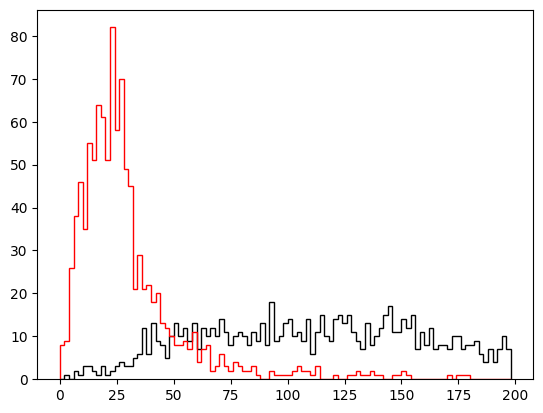

In [65]:
sgsl_2a_1e_pt=[]
sgsl_2a_1u_pt=[]

bgsl_2a_1e_pt=[]
bgsl_2a_1u_pt=[]

sgsl_2a_1l_pt=[]
bgsl_2a_1l_pt=[]

ptsl(sgsl_2a_1e,sgsl_2a_1e_pt)
ptsl(sgsl_2a_1u,sgsl_2a_1u_pt)

ptsl(bgsl_2a_1e,bgsl_2a_1e_pt)
ptsl(bgsl_2a_1u,bgsl_2a_1u_pt)

sgsl_2a_1l_pt=sgsl_2a_1e_pt+sgsl_2a_1u_pt
bgsl_2a_1l_pt=bgsl_2a_1e_pt+bgsl_2a_1u_pt

print(len(sgsl_2a_1l_pt))
print(len(bgsl_2a_1l_pt))





bins=np.arange(0,200,2)
plt.hist(pta, bins=bins, histtype='step', color='black')
plt.hist(bg_pta, bins=bins, histtype='step', color='red')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

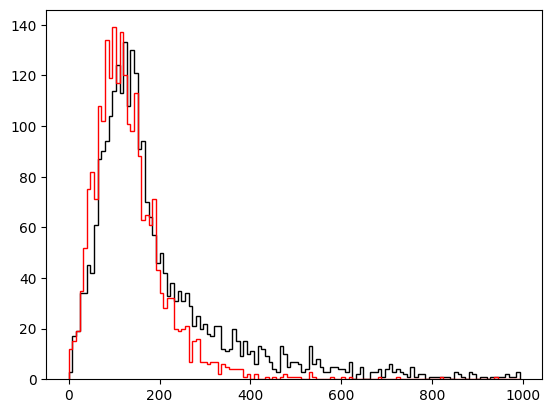

In [45]:
bins=np.arange(0,1000,8)
plt.hist(mlv, bins=bins, histtype='step', color='black')
plt.hist(bg_mlv, bins=bins, histtype='step', color='red')
plt.show

In [9]:
    a1=[]
    b1=[]
    c1=[]
    d1=[]
for i in range(10):
    
     a = len(sg_events[np.where(sg_events[:,18]==i)])
     b = len(bg_events[np.where(bg_events[:,18]==i)])
     c = len(sel_photon[np.where(sel_photon[:,18]==i)])
     d = len(sel_ele[np.where(sel_ele[:,18]==i)])
     print(a)
     a1.append(a)
     b1.append(b)
     c1.append(c)
     d1.append(d)
print(a1)    

2492
3295
2442
1178
407
120
50
14
1
1
[2492, 3295, 2442, 1178, 407, 120, 50, 14, 1, 1]


<function matplotlib.pyplot.show(close=None, block=None)>

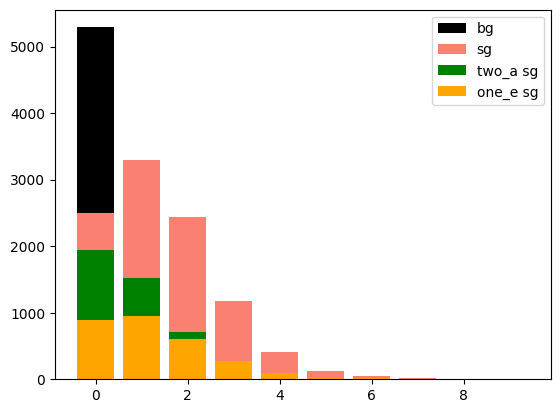

In [66]:
plt.bar(range(len(b1)), b1, color='black', label='bg')
plt.bar(range(len(a1)), a1, color='salmon', label='sg')
plt.bar(range(len(c1)), c1, color='green', label='two_a sg')
plt.bar(range(len(d1)), d1, color='orange', label='one_e sg')
plt.legend(loc = 'upper right')
plt.show